# Basis Pursuit

**Author: M. Ravasi, KAUST**

Welcome to the second exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Learn how to solve a Basis Pursuit problem with PyProximal;
- Compare the performance of different proximal solvers when applied to the same objective function.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal

In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyproximal

from pylops import MatrixMult

In [3]:
def callback(x, xtrue, xerr):
    xerr.append(np.linalg.norm(x-xtrue))

## Problem statement

From a mathematical point of view we seek the sparsest solution that satisfies a system of equations.

$$
argmin_\mathbf{x} \|\mathbf{x}\|_1 \; \text{s.t.} \; \mathbf{Gx} = \mathbf{d}
$$

where the operator $\mathbf{A}$ is of size $N \times M$, and generally $N<M$.

Note that this problem is similar to the more general $L_1$ regularized inversion; however, it presents a stricter condition on the data term which must be satisfied exactly. Similarly, we can also consider the Basis Pursuit Denoise problem

$$
argmin_\mathbf{x} \|\mathbf{x}\|_1 \; \text{s.t.} \;  \|\mathbf{Gx} - \mathbf{d}\|_2 < \epsilon
$$


Let’s start by creating the input vector $\mathbf{x}$, operator $\mathbf{A}$, and data $\mathbf{y}$

In [4]:
n, m = 40, 100
mava = 10

# model
x = np.zeros(m)
iava = np.random.permutation(np.arange(m))[:mava]
x[iava] = np.random.normal(0, 1, mava)

# operator
G = np.random.normal(0, 1, (n, m))
Gop = MatrixMult(G)

# data
d = Gop * x

We focus now on the Basis Pursuit case and use HQS first

HQS
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = Variable	niter = 150

   Itn       x[0]          f           g       J = f + g
     1   3.29351e-01   0.000e+00   1.504e+01   1.504e+01
     2   3.29351e-01   0.000e+00   1.504e+01   1.504e+01
     3   3.27917e-01   0.000e+00   1.500e+01   1.500e+01
     4   3.20868e-01   0.000e+00   1.485e+01   1.485e+01
     5   3.10825e-01   0.000e+00   1.463e+01   1.463e+01
     6   2.99411e-01   0.000e+00   1.438e+01   1.438e+01
     7   2.87613e-01   0.000e+00   1.416e+01   1.416e+01
     8   2.76014e-01   0.000e+00   1.395e+01   1.395e+01
     9   2.64933e-01   0.000e+00   1.375e+01   1.375e+01
    10   2.54232e-01   0.000e+00   1.351e+01   1.351e+01
    16   1.92972e-01   0.000e+00   1.169e+01   1.169e+01
    31   1.78310e-01   0.000e+00   9.654e+00   9.654e+00
    46   1.64675e-01   0.000e+00   9.

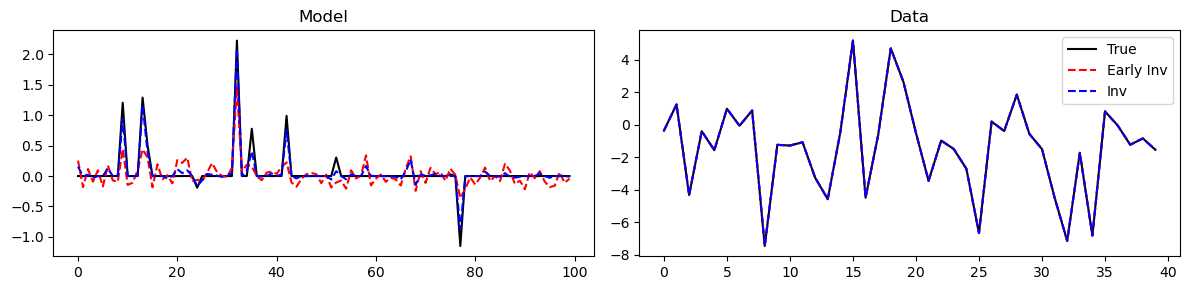

In [5]:
f = pyproximal.AffineSet(Gop, d, niter=20)
g = pyproximal.L1()

tau = 0.9 ** np.arange(150)
xhqs_early = pyproximal.optimization.primal.HQS(f, g, np.zeros_like(x),
                                                tau[:10], niter=10)[0]

xhqs_err = []
xhqs = pyproximal.optimization.primal.HQS(f, g, np.zeros_like(x),
                                          tau, niter=150, show=True,
                                          callback=lambda xest: callback(xest, x, xhqs_err))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xhqs_early, '--r')
axs[0].plot(xhqs, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xhqs_early, '--r', label='Early Inv')
axs[1].plot(Gop * xhqs, '--b', label='Inv')
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

Let's use ADMM now instead

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 1.000000e-01	niter = 150

   Itn       x[0]          f           g       J = f + g
     1   3.29351e-01   0.000e+00   1.504e+01   1.504e+01
     2   3.73490e-01   0.000e+00   1.278e+01   1.278e+01
     3   4.10794e-01   0.000e+00   1.217e+01   1.217e+01
     4   4.27239e-01   0.000e+00   1.176e+01   1.176e+01
     5   4.10302e-01   0.000e+00   1.135e+01   1.135e+01
     6   3.77987e-01   0.000e+00   1.086e+01   1.086e+01
     7   3.47475e-01   0.000e+00   1.059e+01   1.059e+01
     8   3.17673e-01   0.000e+00   1.028e+01   1.028e+01
     9   2.81904e-01   0.000e+00   1.007e+01   1.007e+01
    10   2.49906e-01   0.000e+00   9.912e+00   9.912e+00
    16   1.39356e-01   0.000e+00   9.548e+00   9.548e+00
    31   3.37035e-02   0.000e+00   8.876e+00   8.876e+00
    46   3.29447e-04   0.000e+00

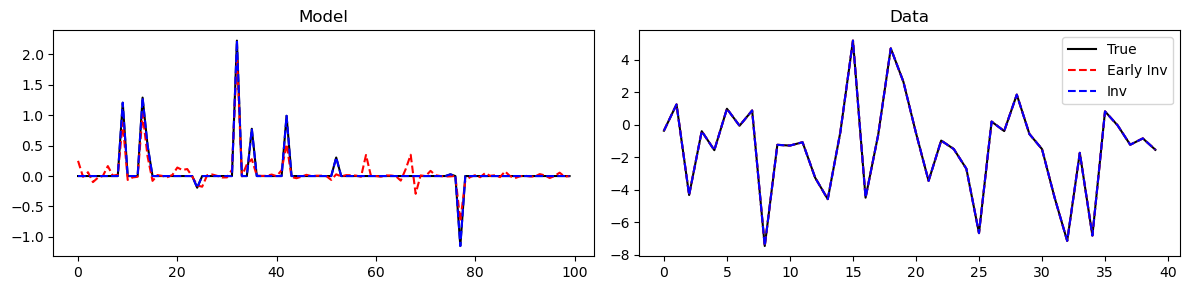

In [6]:
f = pyproximal.AffineSet(Gop, d, niter=20)
g = pyproximal.L1()

xadmm_early = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                                  0.1, niter=10)[0]

xadmm_err = []
xadmm = pyproximal.optimization.primal.ADMM(f, g, np.zeros_like(x),
                                            0.1, niter=150, show=True,
                                            callback=lambda xest: callback(xest, x, xadmm_err))[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xadmm_early, '--r')
axs[0].plot(xadmm, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xadmm_early, '--r', label='Early Inv')
axs[1].plot(Gop * xadmm, '--b', label='Inv')
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

And finally we compare the converge behaviour of the two solvers

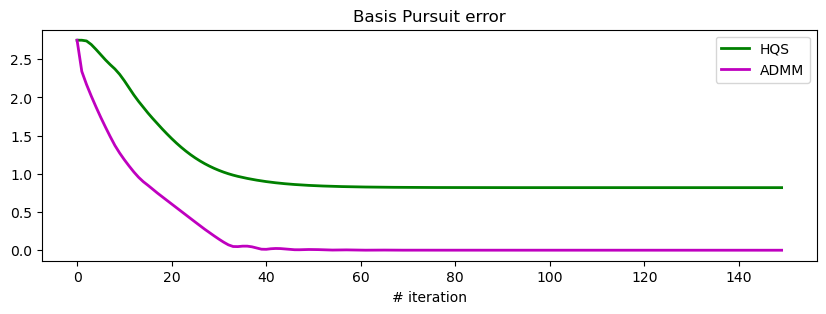

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xhqs_err, "g", lw=2, label="HQS")
ax.plot(xadmm_err, "m", lw=2, label="ADMM")
ax.set_title("Basis Pursuit error")
ax.set_xlabel('# iteration')
ax.legend();

Finally, let's see how we can easily switch to the Basis Pursuit Denoise problem

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L1.L1'>
Proximal operator (g): <class 'pyproximal.proximal.Euclidean.EuclideanBall'>
Linear operator (A): <class 'pylops.basicoperators.matrixmult.MatrixMult'>
Additional vector (z): None
tau = 0.99		mu = 0.004131591528841879
theta = 1.00		niter = 150

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     2   0.00000e+00   0.000e+00   0.000e+00   0.000e+00       0.000e+00
     3   0.00000e+00   9.661e-02   0.000e+00   0.000e+00       9.661e-02
     4   0.00000e+00   6.515e-01   0.000e+00   0.000e+00       6.515e-01
     5   0.00000e+00   1.903e+00   0.000e+00   0.000e+00       1.903e+00
     6   0.00000e+00   3.386e+00   0.000e+00   0.000e+00       3.386e+00
     7   0.00000e+00   4.537e+00   0.000e+00   0.000e+00       4.537e+00
     8   0.

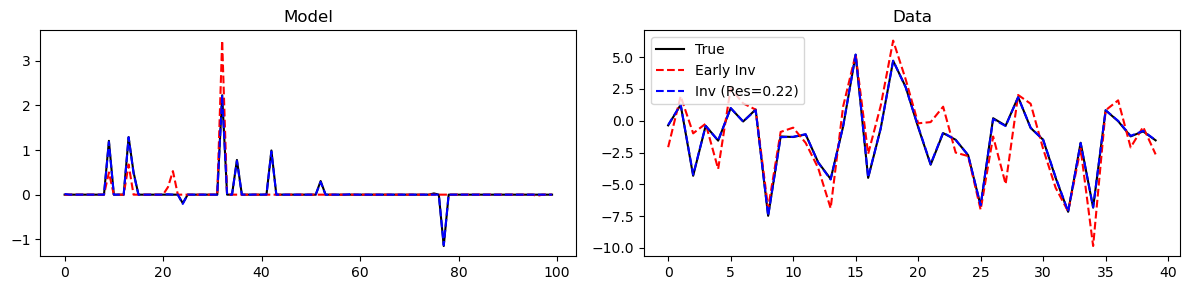

In [8]:
f = pyproximal.L1()
g = pyproximal.proximal.EuclideanBall(d, .1)

L = np.real((Gop.H @ Gop).eigs(1))[0]
tau = .99
mu = tau / L

xpd_early = pyproximal.optimization.primaldual.PrimalDual(f, g, Gop, np.zeros_like(x),
                                                           tau, mu, niter=10)

xpd_err = []
xpd = pyproximal.optimization.primaldual.PrimalDual(f, g, Gop, np.zeros_like(x),
                                                    tau, mu, niter=150, show=True,
                                                    callback=lambda xest: callback(xest, x, xpd_err))

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(x, 'k')
axs[0].plot(xpd_early, '--r')
axs[0].plot(xpd, '--b')
axs[0].set_title('Model')
axs[1].plot(d, 'k', label='True')
axs[1].plot(Gop * xpd_early, '--r', label='Early Inv')
axs[1].plot(Gop * xpd, '--b', label='Inv (Res=%.2f)' % np.linalg.norm(d - Gop @ xpd))
axs[1].set_title('Data')
axs[1].legend()
plt.tight_layout()

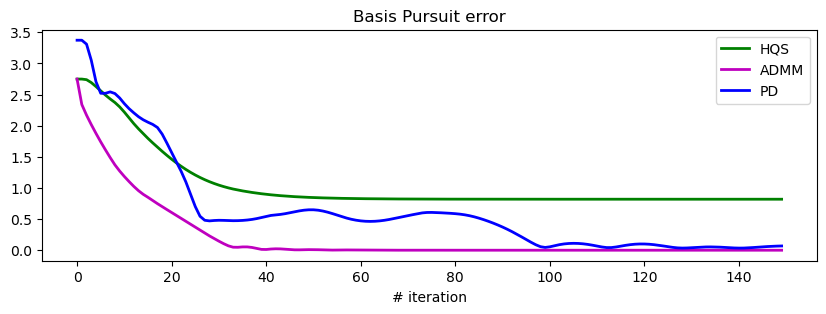

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xhqs_err, "g", lw=2, label="HQS")
ax.plot(xadmm_err, "m", lw=2, label="ADMM")
ax.plot(xpd_err, "b", lw=2, label="PD")
ax.set_title("Basis Pursuit error")
ax.set_xlabel('# iteration')
ax.legend();

## Recap

In this tutorial we have learned to:

- How to set up the Basis Pursuit and Basis Pursuit Denoise problems in PyProximal;
- How to compare different optimizers (and use callbacks to track the converge behaviour of different solutions).